# Reproduce CheXNet: Explore Predictions

## Import other modules and pandas

In [1]:
from __future__ import print_function, division

# pytorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# image imports
from skimage import io, transform
from PIL import Image
import matplotlib.pyplot as plt

# general imports
import os
import time
from shutil import copyfile
from shutil import rmtree

# data science imports
import pandas as pd
import numpy as np
import csv

import random

import cxr_dataset as CXR
import cxp_dataset as CXP
import model_fz as M
import eval_model_fz as E
import submit_chexpert as S

#suppress pytorch warnings about source code changes
import warnings
warnings.filterwarnings('ignore')

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

print(torch.__version__)
print(torchvision.__version__)

Available GPU count:1
0.4.1
0.2.1


## Test data import
Change CheXNet import on NIH data to import of CheXpert data

Sample transformed image:
(29420, 9)
(33, 9)


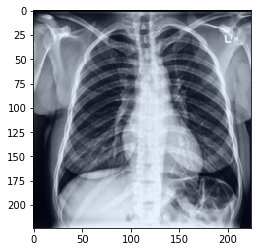

In [9]:
PATH_TO_CSV = "/home/frank_li_zhou/CheXpert-v1.0-small/"
PATH_TO_CSV = "/home/frank_li_zhou/CheXpert-v1.0/"

PATH_TO_IMAGES = "/home/frank_li_zhou/"

# use imagenet mean,std for normalization
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# define torchvision transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.Resize(224), # changed for pytorch 4.0.1
        # because scale doesn't always give 224 x 224, this ensures 224 x
        # 224
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

# create train/val dataloaders
transformed_datasets = {}
transformed_datasets['train'] = CXP.CXPDataset(
    path_to_images=PATH_TO_IMAGES,
    path_to_csv=PATH_TO_CSV,
    fold='train',
    transform=data_transforms['train'],
    #orientation='lat'
    #orientation='ap'
    orientation='pa'
)
transformed_datasets['val'] = CXP.CXPDataset(
    path_to_images=PATH_TO_IMAGES,
    path_to_csv=PATH_TO_CSV,
    fold='val',
    transform=data_transforms['val'],
    #orientation='lat'
    #orientation='ap'
    orientation='pa'
)

#print(transformed_datasets['train'].df.iloc[1])
#print(transformed_datasets['train'][0][0].shape)
#print(transformed_datasets['val'][0][0].shape)

img = random.choice(transformed_datasets['train'])[0]
img = transformed_datasets['train'][0][0]
img -= img.min()
img /= img.max()

print("Sample transformed image:")
plt.imshow(img.permute(1, 2, 0))

print(transformed_datasets['train'].df.shape)
print(transformed_datasets['val'].df.shape)

In [ ]:
PATH_TO_CSV = "/home/frank_li_zhou/CheXpert-v1.0-small/"
PATH_TO_CSV = "/home/frank_li_zhou/CheXpert-v1.0/"
PATH_TO_IMAGES = "/home/frank_li_zhou/"

LOGGER = []

# adam
WEIGHT_DECAY = 1e-4
LEARNING_RATE = 0.0001

# # sgd
# WEIGHT_DECAY = 1e-4
# LEARNING_RATE = 0.01

#torch.cuda.empty_cache()

preds, aucs = M.train_cnn(PATH_TO_IMAGES, PATH_TO_CSV, LEARNING_RATE, WEIGHT_DECAY, orientation='ap')


Running with WD, LR: 0.0001 0.0001
Using orientation: ap
{'val': Compose(
    Resize(size=224, interpolation=PIL.Image.BILINEAR)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
), 'train': Compose(
    Resize(size=224, interpolation=PIL.Image.BILINEAR)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)}
Uncertain labels are positive
Using no uncertain labeling
Size of train set: 161590
Size of val set: 169
Model training start
29 May 2019 10:55:35
Epoch 1/100
----------
29 May 2019 13:12:29
train epoch 1: loss 0.4895 with data size 161590
train epoch complete in 136m 54s
29 May 2019 13:12:39
val epoch 1: loss 0.4802 with data size 169
val epoch complete in 137m 4s
              label       auc
0       Atelectasis  0.830925
1      Cardiomegaly  0.818037
2     Consolidation  0.839590
3             Edema  0.889477
4  Pleural Effusion  0.893914
mean epoch v

In [ ]:
print(time.strftime("%d %b %Y %H:%M:%S", time.gmtime(time.time()-25200)))

In [ ]:
import importlib

importlib.reload(CXP)
importlib.reload(CXR)
importlib.reload(M)
importlib.reload(E)

PATH_TO_MODEL = "/home/frank_li_zhou/reproduce-chexnet/pretrained/checkpoint"
PATH_TO_IMAGES = "/home/frank_li_zhou/"
PATH_TO_CSV = "/home/frank_li_zhou/CheXpert-v1.0-small/"

def recursion_change_bn(module):
    if isinstance(module, torch.nn.BatchNorm2d):
        module.track_running_stats = 1
    else:
        for i, (name, module1) in enumerate(module._modules.items()):
            module1 = recursion_change_bn(module1)
    return module

checkpoint = torch.load(PATH_TO_MODEL, map_location=lambda storage, loc: storage)
model = checkpoint['model']
for i, (name, module) in enumerate(model._modules.items()):
    module = recursion_change_bn(model)

# put model on GPU
model = model.cuda()

# use imagenet mean,std for normalization
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# define torchvision transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.Resize(224), # changed for pytorch 4.0.1
        # because scale doesn't always give 224 x 224, this ensures 224 x
        # 224
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

preds, metric = E.make_pred_multilabel(data_transforms, model, PATH_TO_IMAGES, PATH_TO_CSV, 'auc')

auc = metric.as_matrix(columns=metric.columns[1:])
print(auc[~np.isnan(auc)].mean())

In [ ]:
print(metric)

In [25]:
import importlib

importlib.reload(CXP)
importlib.reload(CXR)
importlib.reload(M)
importlib.reload(E)
importlib.reload(S)

PATH_TO_CHECKPOINT = "/home/frank_li_zhou/reproduce-chexnet/results_05172019_adam_entire_uones/checkpoint_3"
PATH_TO_CSV = "/home/frank_li_zhou/reproduce-chexnet/valid_image_paths.csv"
PATH_TO_IMAGES = "/home/frank_li_zhou/reproduce-chexnet"

S.run_chexpert(PATH_TO_CHECKPOINT, PATH_TO_IMAGES, PATH_TO_CSV)

Available GPU count:1
,Image Index,prob_Atelectasis,prob_Cardiomegaly,prob_Consolidation,prob_Edema,prob_Pleural Effusion
0,CheXpert-v1.0/valid/patient00000/study1/view1_frontal.jpg,0.010257040150463581,0.01910395175218582,0.031947001814842224,0.0028430516831576824,0.07224275916814804
1,CheXpert-v1.0/valid/patient00000/study1/view2_lateral.jpg,0.02356710471212864,0.010515031404793262,0.03928971290588379,0.0058294665068387985,0.0368463508784771
2,CheXpert-v1.0/valid/patient00000/study2/view1_frontal.jpg,0.2641124725341797,0.8834467530250549,0.11526404321193695,0.04728170856833458,0.33192265033721924

